In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import pycountry 
from langdetect import detect
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r"train_data.txt",
                    sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
test = pd.read_csv(r"test_data.txt",
                  sep=':::',names=['Title', 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [4]:
train.describe(include='object').T


,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [5]:
train.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [6]:
train.duplicated().sum() #No duplicates

0

In [7]:
train.Genre.unique() #No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [8]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [9]:
test.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [10]:
test.duplicated().sum() #No duplicates

0

In [11]:
train.loc[train['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [12]:
#We discover that there is more than one language so we need to handle that
#First we need to discover different languages
def detect_language(text):
    try:
        #Returning the name 'English instide of en'
        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train['Language'] = train['Description'].apply(detect_language)
test['Language'] = test['Description'].apply(detect_language)
train.head()

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,english
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,english
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,english
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,english
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,english


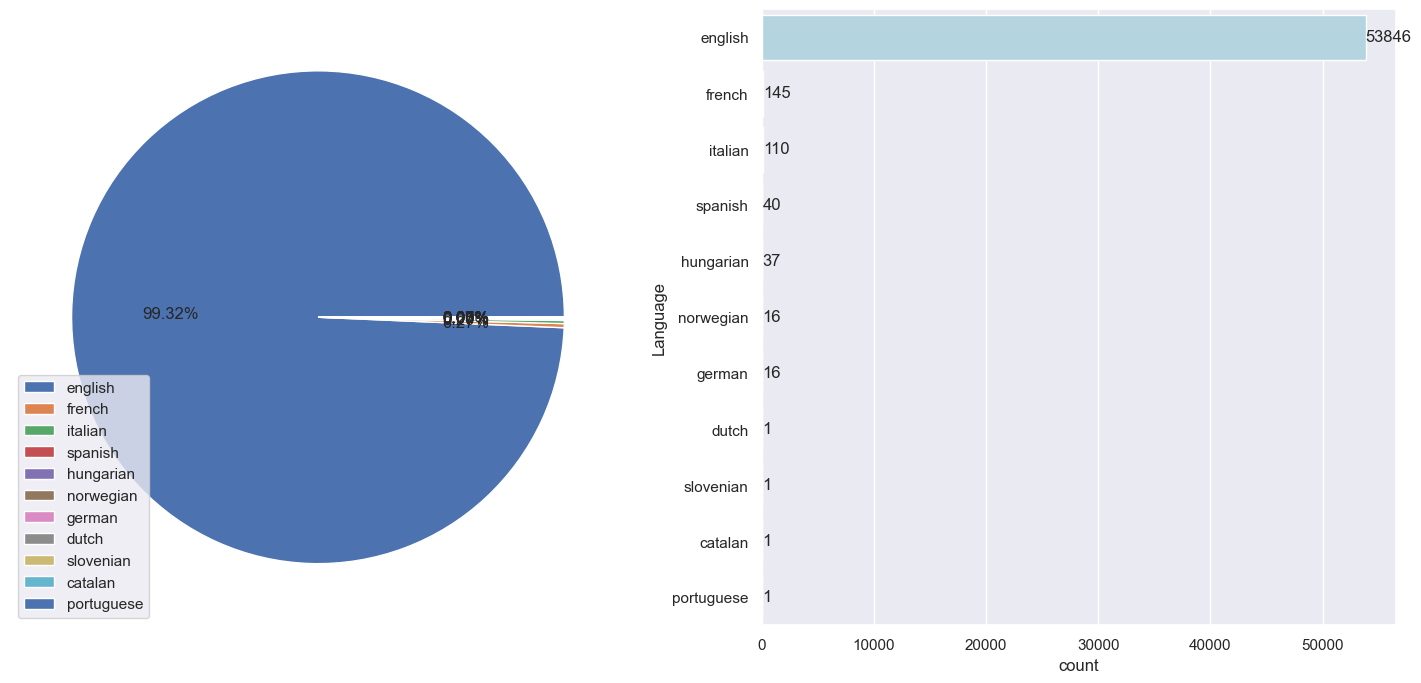

In [13]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train,y='Language',order=train.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

In [14]:
#Descriptions included HTTP links
train.loc[train['Description'].str.contains(r'http\S+')].shape[0]

9

In [15]:
#For example
train.loc[train['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]
#So we need to remove them from our text

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

In [16]:
def clean_text(text):
    # Remove strange pattern in different languages if exist 
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    # Remove twitter handles
    text = re.sub(r'@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub(f'[{string.punctuation}]','',text)
    # Remove numbers
    text = re.sub(f'[{string.digits}]','',text)
    # Remove single charachters 
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    return text

In [17]:
#Clean Descriptions
train['Description'] = train['Description'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

In [18]:
train[~train.Language.isin(['english'])]

,Title,Genre,Description,Language
210,Divorzio alla siciliana (1963),comedy,Il barone Fifě ha bisogno di un erede per ave...,italian
242,Túlvilági beszélö (1992),documentary,Tollas Tibor az os fordulatot kovetoen katona...,hungarian
282,"""Boogie-woogie 47"" (1980)",drama,En plusieurs familles de Montréal passent lé...,french
806,Iszony (1965),drama,Mail to author for translation Karasz Nelli a...,hungarian
837,Entretien avec Anne Claire Poirier (2005),biography,Long métrage documentaire qui explore la carr...,french
...,...,...,...,...
53697,Fantasmi e ladri (1959),comedy,Annunziata ha letto diecimila gialli spopola ...,italian
53712,Due notti con Cleopatra (1954),comedy,Cleopatra č una donna bellissima ma ha un pic...,italian
53878,Gyilkos kedv (1997),drama,Kora delutan egy iskolabol hazatero kislany c...,hungarian
54165,Az áldozat (1994),documentary,Mail author for translation Az os forradalom ...,hungarian


In [19]:
#Translate other languages
def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train.loc[~train['Language'].isin(['english']), 'Description']=train.loc[~train['Language'].isin(['english']),'Description'].apply(trans)
test.loc[~test['Language'].isin(['english']), 'Description']=test.loc[~test['Language'].isin(['english']),'Description'].apply(trans)

In [20]:
train.drop(columns='Language',inplace=True)
test.drop(columns='Language',inplace=True)

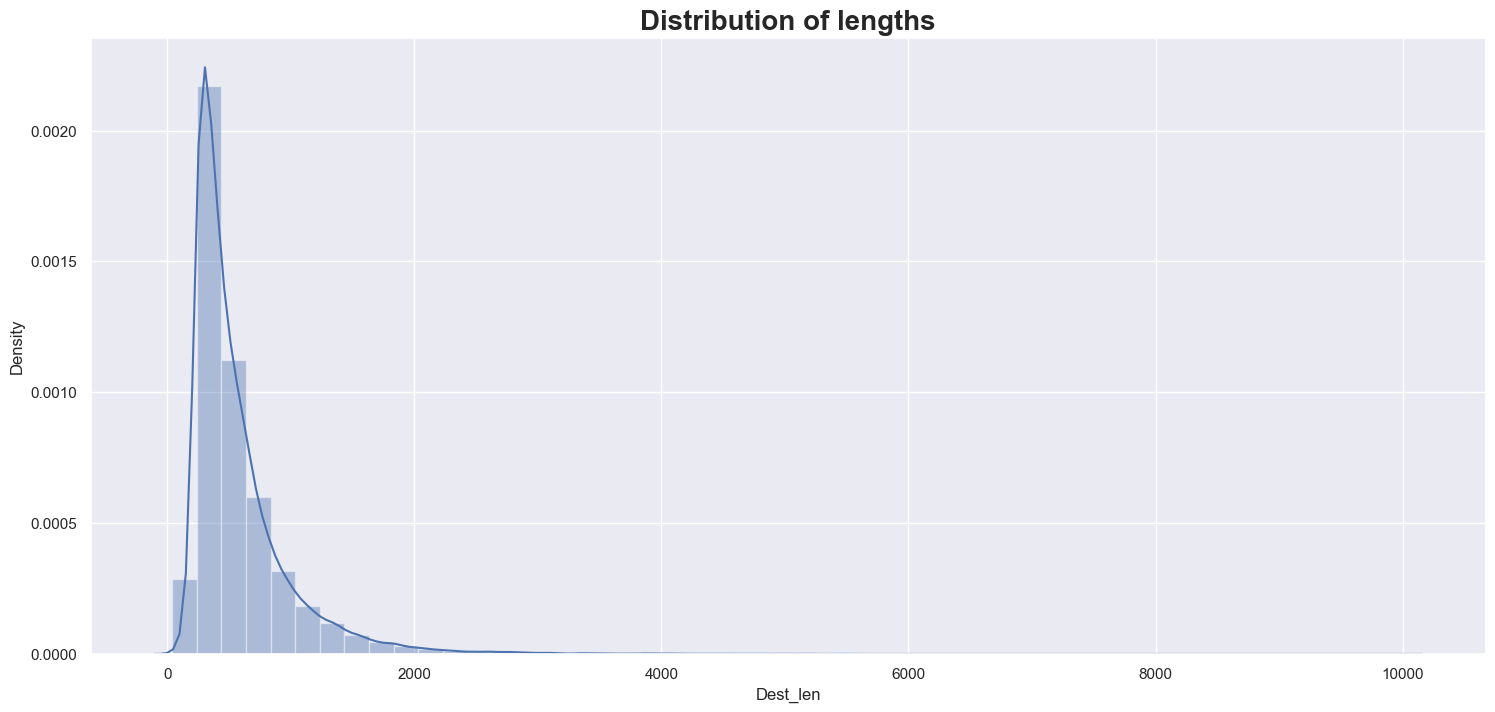

In [21]:
#Distribution of text lengths
train['Dest_len'] = train['Description'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()

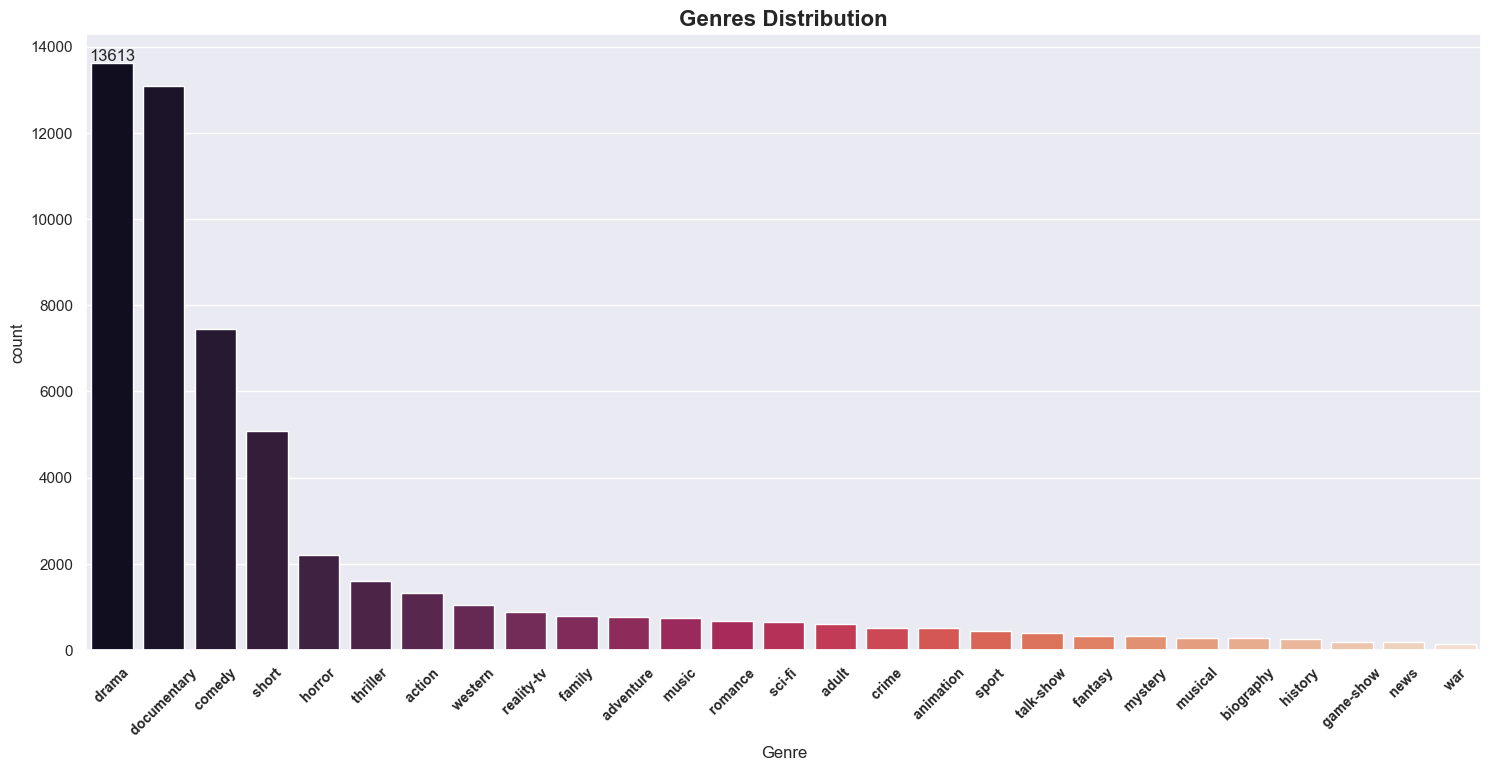

In [22]:
ax=sns.countplot(data=train,x='Genre',order=train.Genre.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
plt.title('Genres Distribution',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,fontweight='bold',fontsize=10)
plt.show()

In [23]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                                   ngram_range=(1,1), #Capture only single words in each text(unigrams)
                                   stop_words='english',#Remove stop_words
                                   min_df=2)#Ignore words that appears less than 2 times
x_train = tfidf_vectorizer.fit_transform(train['Description'])
x_test = tfidf_vectorizer.transform(test['Description'])

In [24]:
#We conclude before that drama and documentary have the majority of our data,
#so to avoid imbalance data in our model we will make randomoversampling
#Notice that the accuracy before sampling will be < the accuracy after oversampling
sampler = RandomOverSampler()
#We will pass to it the output of TfidfVectorizer from train data
x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['Genre'])

In [25]:
# #Let's take a look on genre distribution
# sns.countplot(data=y_train_resampled,x=y_train_resampled.values,palette='rocket')
# plt.xticks(rotation=45)
# plt.show()

In [26]:
#Double check for length of our data 
print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [27]:
#Get the actual solutions to compare it with our predictions
y_actual = pd.read_csv(r"test_data_solution.txt",
                      sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [28]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5436162361623617
Running Time :  0.84 Secounds


In [29]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.37      0.49      0.42      1314
       adult        0.50      0.53      0.52       590
   adventure        0.33      0.25      0.28       775
   animation        0.31      0.22      0.26       498
   biography        0.05      0.03      0.04       264
      comedy        0.57      0.53      0.55      7446
       crime        0.16      0.17      0.16       505
 documentary        0.72      0.71      0.72     13096
       drama        0.64      0.57      0.60     13612
      family        0.26      0.23      0.24       783
     fantasy        0.17      0.15      0.16       322
   game-show        0.80      0.66      0.72       193
     history        0.10      0.07      0.08       243
      horror        0.52      0.68      0.59      2204
       music        0.40      0.72      0.51       731
     musical        0.19      0.09      0.13       276
     mystery        0.15      0.08      0.11       318
        n

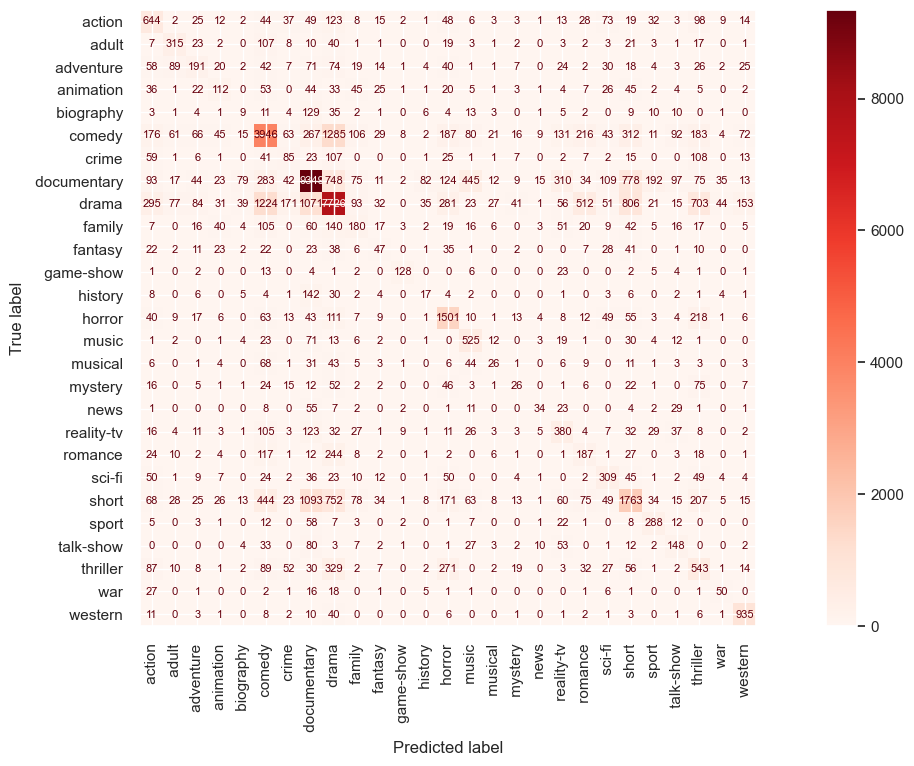

In [30]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [31]:
#We got low accuracy due to insufficient data for other categories 
#So the model trained alot about drama and documentary movies so it's hard to discover the others
#Now let's try another approach and see the effect on data
y_train_modified = train['Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')

In [32]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.6947416974169742
Running Time :  0.11 Secounds
